# Experiments with Shapelet Transformations and Extreme Gradient Boosting

Importing libraries:

In [1]:
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from utils import get_clf_report_dfs, plot_confusion_matrix

Defining constants:

In [2]:
RANDOM_SEED=42
MODEL_NAME="shapelet+XGB"
RESULTS_DIR=f"./results/{MODEL_NAME}"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.random.seed(RANDOM_SEED)

Loading the data:

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

Extracting Shapelets, training XGB and tuning hyperparameters via grid search, using validation accuracy for model selection:

In [4]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
}

trials = [] 
best_score = 0.0
best_model = None

for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for learning_rate in param_grid["learning_rate"]:
            for subsample in param_grid["subsample"]:
                print(f"Training with n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}")
                clf = ShapeletTransformClassifier(
                    estimator=XGBClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        random_state=RANDOM_SEED,
                        objective='multi:softmax',
                        num_class=len(np.unique(y_train))
                    ),
                    n_shapelet_samples=X_train.shape[0]*2,
                    random_state=RANDOM_SEED,
                )
                clf.fit(X_train, y_train)
                val_preds = clf.predict(X_val)
                acc = accuracy_score(y_val, val_preds)
                trials.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'subsample': subsample,
                    'accuracy': acc
                })
                if acc > best_score:
                    best_score = acc
                    best_model = clf

trials_df = pd.DataFrame(trials).sort_values(by='accuracy', ascending=False)
trials_df.style.background_gradient(cmap='Blues', subset=['accuracy'])

Training with n_estimators=100, max_depth=3, learning_rate=0.05, subsample=0.8
Training with n_estimators=100, max_depth=3, learning_rate=0.05, subsample=1.0
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8
Training with n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0
Training with n_estimators=100, max_depth=5, learning_rate=0.05, subsample=0.8
Training with n_estimators=100, max_depth=5, learning_rate=0.05, subsample=1.0
Training with n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8
Training with n_estimators=100, max_depth=5, learning_rate=0.1, subsample=1.0
Training with n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.8
Training with n_estimators=200, max_depth=3, learning_rate=0.05, subsample=1.0
Training with n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.8
Training with n_estimators=200, max_depth=3, learning_rate=0.1, subsample=1.0
Training with n_estimators=200, max_depth=5, learning_rate

,n_estimators,max_depth,learning_rate,subsample,accuracy
3,100,3,0.100000,1.000000,0.825000
11,200,3,0.100000,1.000000,0.825000
8,200,3,0.050000,0.800000,0.812500
6,100,5,0.100000,0.800000,0.800000
9,200,3,0.050000,1.000000,0.800000
12,200,5,0.050000,0.800000,0.800000
14,200,5,0.100000,0.800000,0.800000
0,100,3,0.050000,0.800000,0.787500
4,100,5,0.050000,0.800000,0.787500
5,100,5,0.050000,1.000000,0.787500


Saving the best model:

In [5]:
file = open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.pkl"), 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

Getting the number of features used for classification:

In [6]:
print(f"Number of feautures: {best_model.n_dims_}")

Number of feautures: 150


Displaying model performance on the test set:

In [7]:
start_time = time.time()
y_pred = best_model.predict(X_test)
inference_time = time.time() - start_time

with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_inference_time.json"), 'w') as f:
    json.dump({"inference time [s]": inference_time}, f)

np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.679012,0.669873,0.671839,0.701261,0.704027,0.677451,0.679012


In [8]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.000000,0.000000,0.000000,4.000000
bigball,0.500000,0.800000,0.615385,5.000000
box,1.000000,1.000000,1.000000,4.000000
button,0.600000,0.500000,0.545455,6.000000
case,0.800000,0.800000,0.800000,5.000000
cube,0.666667,0.500000,0.571429,4.000000
cylinder,0.600000,0.600000,0.600000,5.000000
empty,0.833333,1.000000,0.909091,5.000000
jenga,0.285714,0.500000,0.363636,4.000000
labello,1.000000,0.400000,0.571429,5.000000


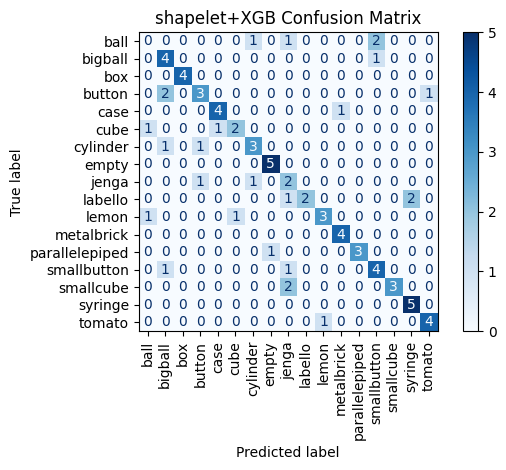

In [9]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)